In [1]:
import pickle 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
with open('simulation_results/metrics.pickle', 'rb') as file:
    metrics = pickle.load(file)
    
with open('simulation_results/selection.pickle', 'rb') as file:
    selection = pickle.load(file)
    
with open('simulation_results/abogados.pickle', 'rb') as file:
    lawyers = pickle.load(file)
    
with open('simulation_results/decodificacion.pickle', 'rb') as file:
    specialty_decod = pickle.load(file)
    
specialty_decod = {key: value.replace("n1", "") for key, value in specialty_decod.items()}

In [28]:
metrics[0]

{'rep': 0,
 'saa': {'la': 307,
  'ns': 385,
  'nb': 89,
  'ra': 7715.140000000001,
  'tta': array([1389., 1246., 1279.,  748.,  871.,  239.,  139.,   58.,    0.,
          299., 1825.,    0.,  729.,  767., 1569., 1608., 1793., 1649.,
            0.,  675.,  424.,    0.,  584.])},
 'greedy': {'la': 311,
  'ns': 385,
  'nb': 90,
  'ra': 7621.504003600001,
  'tta': array([1249.       , 1358.       , 1307.       , 1263.9999895,
          803.000039 ,  319.       ,  307.       ,   58.       ,
            0.       ,  279.       , 1825.       ,    0.       ,
          750.       ,  572.       , 1794.       , 1656.       ,
         1424.       , 1671.99997  ,    0.       ,  675.       ,
           40.       ,    0.       ,  426.       ])}}

# Analisis de los tiempos de los abogados #

In [3]:
areas = set()
for area_l in lawyers["areas"]:
    for area in area_l: areas.add(area)

area_dict = {area: [] for area in areas}
for i, area_l in enumerate(lawyers["areas"]):
    for area in area_dict:
        if area in area_l:
            area_dict[area].append(i)
            
A = len(area_dict)
area_dict

{3: [14, 15, 16, 17],
 292: [21],
 168: [19],
 74: [3, 4, 5, 6, 9, 12, 13],
 52: [3, 4, 14, 15, 16, 17],
 189: [10],
 119: [0, 1, 2],
 153: [18],
 221: [7, 8, 11],
 94: [3, 4, 5, 6, 9, 13, 20, 22],
 63: [3, 4, 5, 6, 9, 12, 13]}

In [4]:
W = len(metrics)
L = len(metrics[0]['saa']['tta'])

In [5]:
assignments = np.zeros((2, W))
rating = np.zeros((2, W))
droped = np.zeros((2, W))
total = np.zeros(W)
time = np.zeros((2, W, L))
data = {"la": assignments, "ns": total, "nb": droped, "ra": rating, "tta": time}

for dicc in metrics:
    week = dicc["rep"]
    for i, key in enumerate(dicc["saa"].keys()):
        if key != "ns":
            data[key][0, week] = dicc["saa"][key]
            data[key][1, week] = dicc["greedy"][key]
        else:
            if dicc["saa"][key] == dicc["greedy"][key]:
                data[key][week] = dicc["saa"][key]
            else:
                data[key][week] = "SON DISTINTOS"

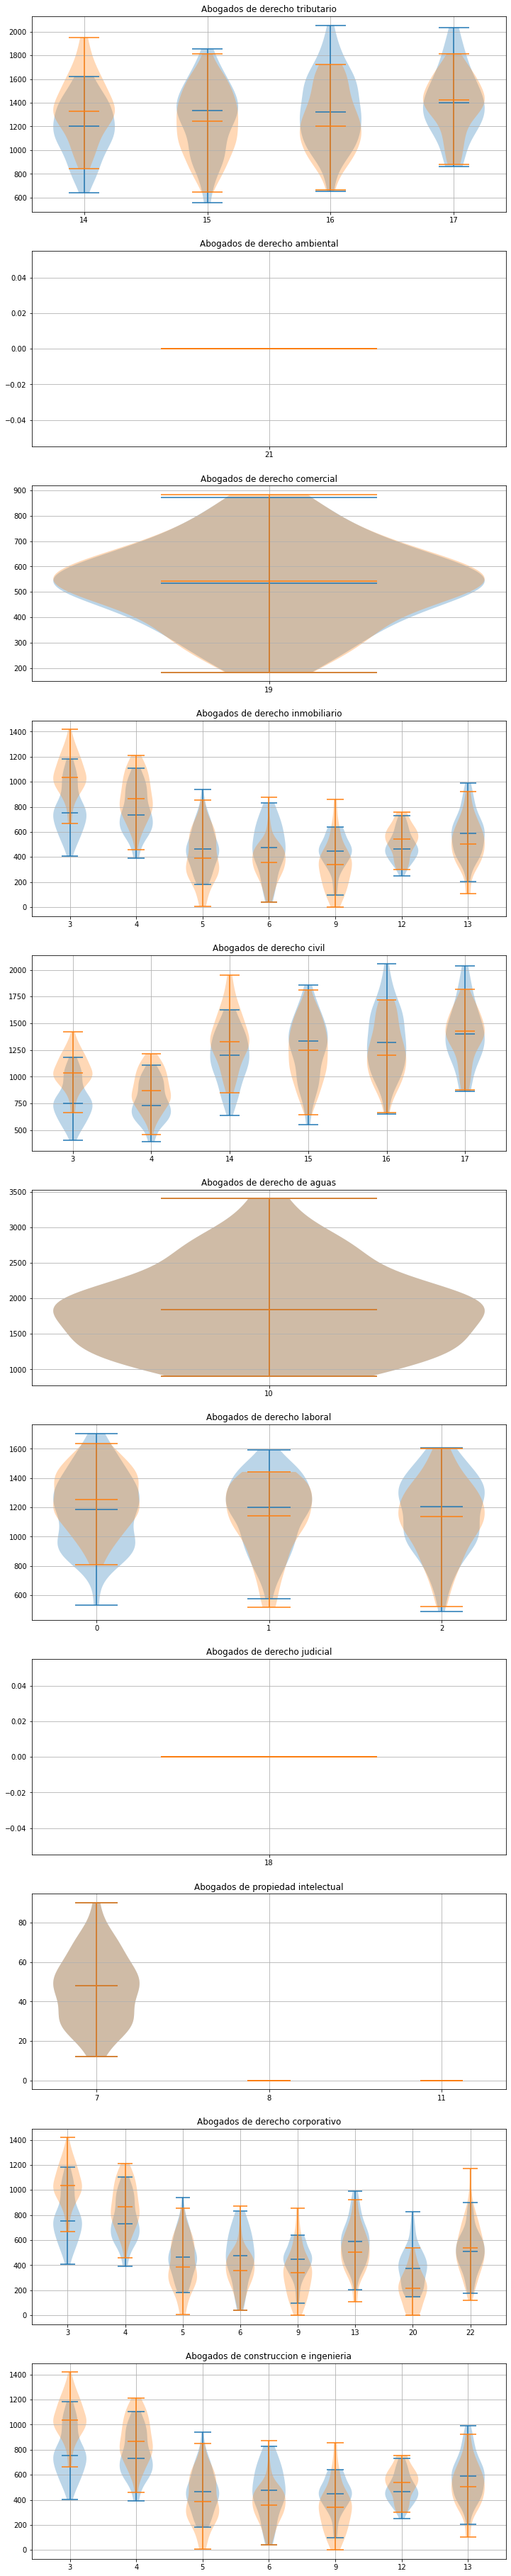

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6 * A))


for ax1, key in zip(axs, area_dict.keys()):
    parts1 = ax1.violinplot(time[0, :, area_dict[key]].T, showmedians=True)
    parts2 = ax1.violinplot(time[1, :, area_dict[key]].T, showmedians=True)
    ax1.set_xticks([y for y in range(1, len(area_dict[key])+1)], labels=area_dict[key])
    ax1.set_title(f"Abogados de {specialty_decod[key]}")
    ax1.grid()
    
plt.show()

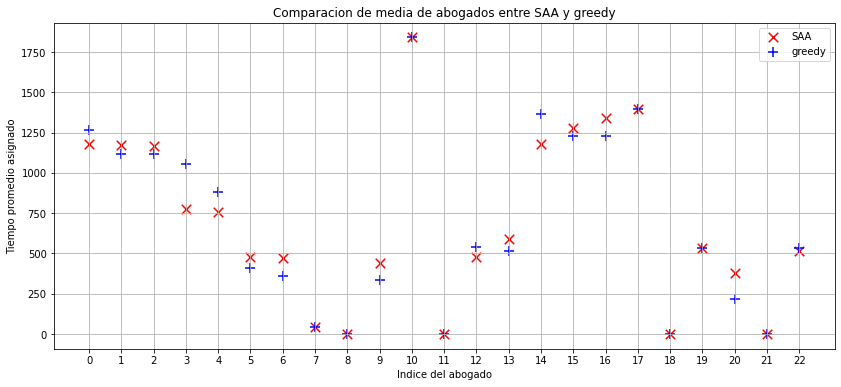

In [8]:
time.mean(axis=1).round(2)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.scatter(np.arange(23), time.mean(axis=1)[0].round(2), marker="x", color="r", s=90)
ax.scatter(np.arange(23), time.mean(axis=1)[1].round(2), marker="+", color="b", s=90)
ax.set_xticks(np.arange(23))
ax.grid()
ax.legend(["SAA", "greedy"])
ax.set_ylabel("Tiempo promedio asignado")
ax.set_xlabel("Indice del abogado")
ax.set_title("Comparacion de media de abogados entre SAA y greedy")
plt.show()

Las asignaciones realizadas por parte de greedy y SAA son muy similares. Sorprende que los abogados 8, 11, 18 y 21 no son asignados por ningun algoritmo a ningun servicio durante toda la simulación.

# Correlacion entre cantidad de servicios de la repeticion y rating #

In [9]:
print(
    f"Promedio SAA: {rating.mean(axis=1)[0]}",
    f"Promedio greedy: {rating.mean(axis=1)[1]}", sep="\n"
)

print(
    f"\nPromedio SAA por servicio: {(rating / total).mean(axis=1)[0]}",
    f"Promedio greedy por servicio: {(rating / total).mean(axis=1)[1]}", sep="\n"
)

Promedio SAA: 7147.384462180038
Promedio greedy: 7129.772852433744

Promedio SAA por servicio: 19.52195714380051
Promedio greedy por servicio: 19.474747776121706


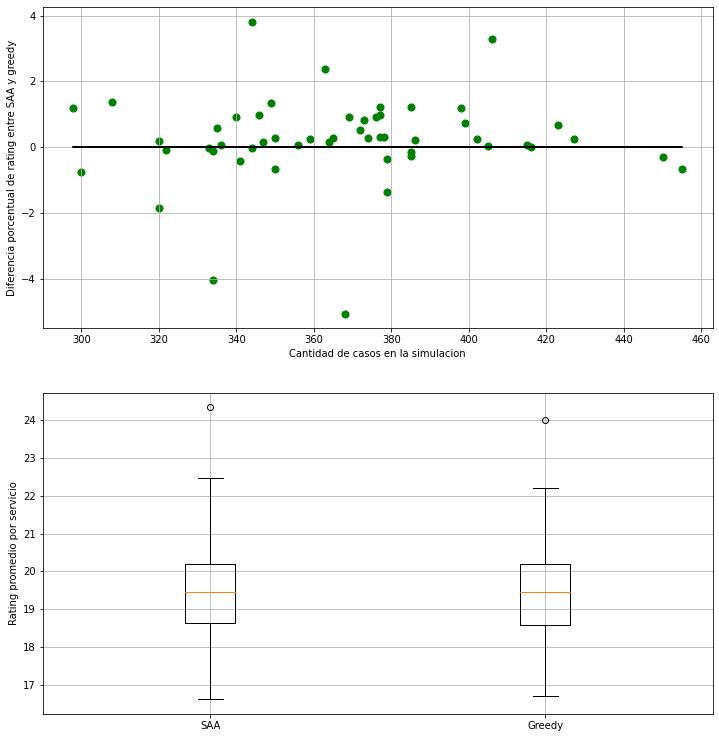

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 13))

scaled_rating = rating / total

diff = 100 * ((scaled_rating[0] - scaled_rating[1]) / scaled_rating[0])
ax1.scatter(total, diff, marker="o", c="g", s=50)
ax1.plot(total, total*0, "k")
ax1.set_xlabel("Cantidad de casos en la simulacion")
ax1.set_ylabel("Diferencia porcentual de rating entre SAA y greedy")
ax1.grid()

ax2.boxplot(scaled_rating.T)
ax2.set_ylabel("Rating promedio por servicio")
ax2.set_xticks([1, 2], ["SAA", "Greedy"])
ax2.grid()

plt.show()

In [11]:
diff.mean()

0.0006130060095270726

In [12]:
np.corrcoef(total, diff)

array([[1.        , 0.04864012],
       [0.04864012, 1.        ]])

Casi no hay correlacion entre la cantidad de servicios que llegaron en el año y la diferencia entre SAA y greedy

# Servicios botados #

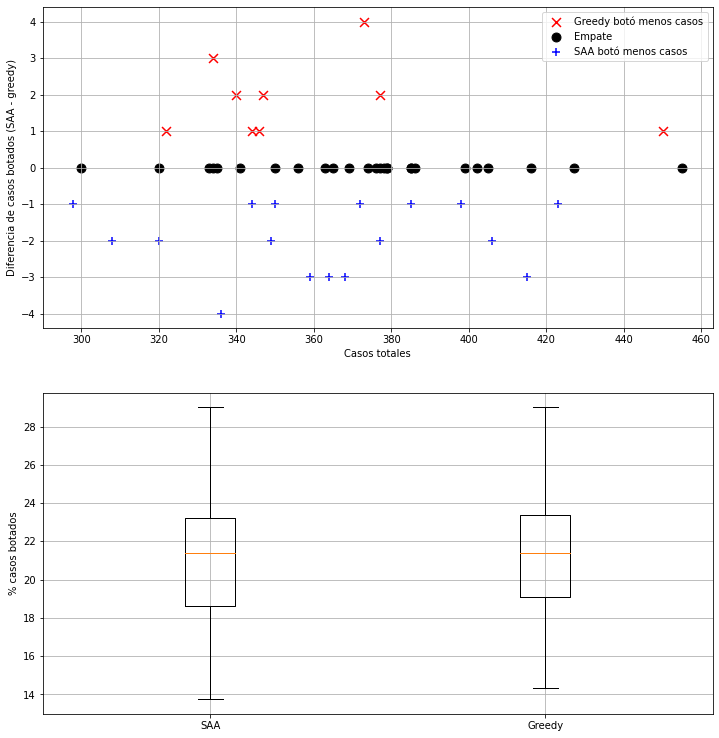

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 13))

ax1.scatter(total[droped[0] - droped[1] > 0],
            (droped[0] - droped[1])[droped[0] - droped[1] > 0],
            marker="x", c="r", s=80)
ax1.scatter(total[droped[0] - droped[1] == 0],
            (droped[0] - droped[1])[droped[0] - droped[1] == 0],
            marker="o", c="k", s=80)
ax1.scatter(total[droped[0] - droped[1] < 0],
            (droped[0] - droped[1])[droped[0] - droped[1] < 0],
            marker="+", c="b", s=80)
ax1.legend(["Greedy botó menos casos", "Empate", "SAA botó menos casos"])
ax1.set_xlabel("Casos totales")
ax1.set_ylabel("Diferencia de casos botados (SAA - greedy)")
ax1.grid()

ax2.boxplot(100 * (droped / total).T)
ax2.set_xticks([1, 2], ["SAA", "Greedy"])
ax2.grid()
ax2.set_ylabel("% casos botados")

plt.show()

In [33]:
print(droped.mean(axis=1))

lost = len(droped[0][droped[0] - droped[1] > 0])
tie = len(droped[0][droped[0] - droped[1] == 0])
won = len(droped[0][droped[0] - droped[1] < 0])

print(f"Ganamos {won} veces, perdimos {lost} veces y hubo {tie} empates") 

[77.19230769 77.5       ]
Ganamos 17 veces, perdimos 9 veces y hubo 26 empates


# Asignaciones #

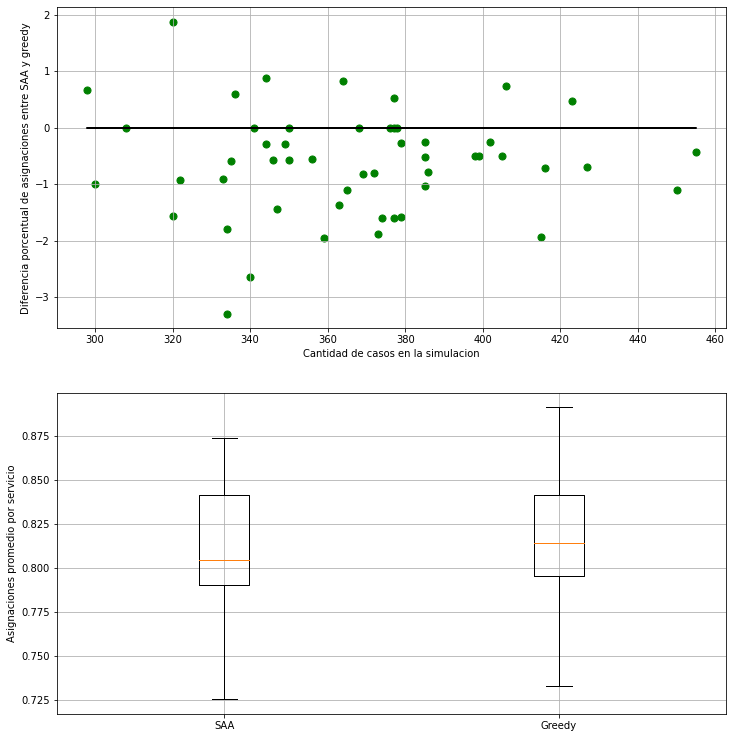

In [18]:
scaled_assignments = assignments / total

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 13))

diff2 = 100 * ((scaled_assignments[0] - scaled_assignments[1]))
ax1.scatter(total, diff2, marker="o", c="g", s=50)
ax1.plot(total, total*0, "k")
ax1.set_xlabel("Cantidad de casos en la simulacion")
ax1.set_ylabel("Diferencia porcentual de asignaciones entre SAA y greedy")
ax1.grid()

ax2.boxplot(scaled_assignments.T)
ax2.set_ylabel("Asignaciones promedio por servicio")
ax2.set_xticks([1, 2], ["SAA", "Greedy"])
ax2.grid()

plt.show()

# Selection #